In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import rho_plus as rp

theme, cs = rp.mpl_setup(False)

torch.manual_seed(42)
device = 'cuda'

In [5]:
from torch.utils.data import Dataset, DataLoader, random_split

batch_size = 16
target = 'yield'

class MyDataset(Dataset):
    def __init__(self, inputs, target):
        self.inputs = inputs.values.astype(np.float32)
        self.labels = target.values.astype(np.float32)

        self.inputs = torch.from_numpy(self.inputs).to(device)
        self.labels = torch.from_numpy(self.labels).to(device)

    @property
    def dim_x(self) -> int:
        return self.inputs.shape[1]

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        return self.inputs[index], self.labels[index].unsqueeze(0)


all_data = pd.read_feather('datasets/steels_featurized.feather')

label_cols = ['yield']

input_cols = [c for c in all_data.columns if c not in label_cols]

inputs = all_data
print(inputs[input_cols].shape)

train_dataset = MyDataset(inputs[input_cols], inputs[target])

# use 20% of training data for validation
train_set_size = int(len(train_dataset) * 0.8)
valid_set_size = len(train_dataset) - train_set_size

# split the train set into two
seed = torch.Generator().manual_seed(42)
train_dataset, valid_dataset = random_split(train_dataset, [train_set_size, valid_set_size], generator=seed)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

(312, 54)


In [51]:
import lightning as L

class PandasLogger(L.pytorch.loggers.Logger):
    def __init__(self):
        super().__init__()
        self.rows = []

    def log_hyperparams(self, params, *args, **kwargs):
        pass

    def log_metrics(self, metrics, step=None):
        model_type = 'none'
        row = {'step': step}
        for k in metrics:
            if k.startswith('valid_') and metrics[k] is not None:
                model_type = 'valid'
                row[k.removeprefix('valid_')] = metrics[k]
            elif k.startswith('train_') and metrics[k] is not None:
                model_type = 'train'
                row[k.removeprefix('train_')] = metrics[k]
            elif k.startswith('test_') and metrics[k] is not None:
                model_type = 'test'
                row[k.removeprefix('test_')] = metrics[k]
            else:
                row[k] = metrics[k]

        row['step'] = step
        row['kind'] = model_type
        self.rows.append(row)

    @property
    def version(self):
        return 0

    @property
    def name(self):
        return 'pandas'

    def finalize(self, status):
        self.df = pd.DataFrame(self.rows)


class MLP(L.LightningModule):
    #'128-64-16'
    def __init__(self, input_size, out_dim=1, dims=(1024, 512, 256, 128, 64, 32), lr=1e-4):
        super().__init__()
        self.dims = dims
        self.lr = lr

        self.layers = []
        i = 0
        prev_dim = input_size
        for dim in (*dims, out_dim):
            fc = nn.Linear(prev_dim, dim)
            bn = nn.BatchNorm1d(dim)
            act = nn.SiLU()
            mod = nn.Sequential(fc, bn, act)
            self.add_module(f'layer{i}', mod)
            self.layers.append(mod)

            prev_dim = dim
            i += 1

        self.out = nn.Linear(dim, 1) # type: ignore

    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer(out)

        return torch.expm1(self.out(out) + 7.5)

    def loss(self, batch, batch_idx):
        inputs, target = batch
        output = self(inputs)
        loss = F.l1_loss(output, target, reduction='mean')
        return loss

    def training_step(self, batch, batch_idx):
        loss = self.loss(batch, batch_idx)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.loss(batch, batch_idx)
        self.log('valid_loss', loss)
        return loss

    def configure_optimizers(self):
        optim = torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=0.03)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, 100, eta_min=1e-4)
        return {
            'optimizer': optim,
            'lr_scheduler': scheduler
        }

In [60]:
import lightning.pytorch.callbacks as callbacks
model = MLP(len(input_cols), dims=(2048, 2048), lr=5e-3)
trainer = L.Trainer(logger=PandasLogger(), enable_checkpointing=False, callbacks=[
    # callbacks.LearningRateFinder(min_lr=1e-5, max_lr=1e-2, mode='exponential'),
    callbacks.RichProgressBar(refresh_rate=4)
], max_epochs=100, log_every_n_steps=10, check_val_every_n_epoch=1)
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=valid_loader)

display(trainer.logger.df.pivot_table(index='epoch', columns='kind', values='loss').min())

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name   ┃ Type       ┃ Params ┃
┡━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ layer0 │ Sequential │  116 K │
│ 1 │ layer1 │ Sequential │  4.2 M │
│ 2 │ layer2 │ Sequential │  2.1 K │
│ 3 │ out    │ Linear     │      2 │
└───┴────────┴────────────┴────────┘

Trainable params: 4.3 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 4.3 M                                                                                                
Total estimated model params size (MB): 17

Output()

/home/nicholas/anaconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: 
The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/home/nicholas/anaconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: 
The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

`Trainer.fit` stopped: `max_epochs=100` reached.


kind
train    68.372002
valid    75.197723
dtype: float64

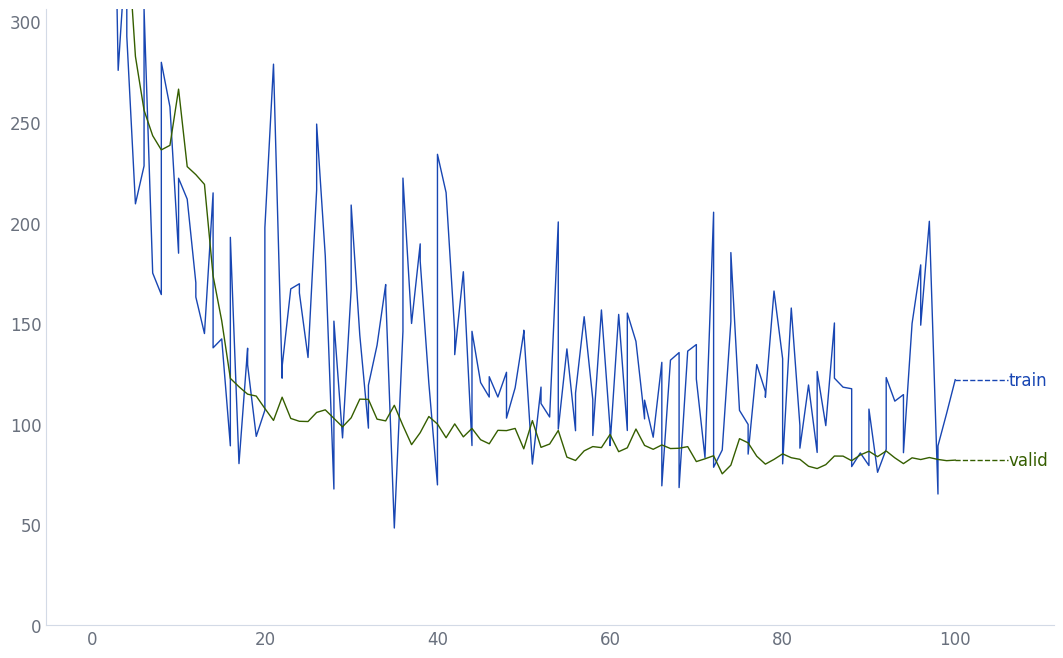

In [61]:
logs = trainer.logger.df
logs['epoch_frac'] = logs['epoch'] + logs.groupby('epoch')['step'].transform(lambda x: (x - x.min()) / (x.max() - x.min() + 1e-12))
fig, ax = plt.subplots(figsize=(13, 8))
for kind in sorted(set(logs['kind'])):
    ax.plot('epoch_frac', 'loss', data=logs.query('kind == @kind'), label=kind, lw=1)

ax.set_ylim(0, logs[logs['epoch'] >= int(logs['epoch'].max() * 0.05)]['loss'].max())
rp.line_labels()
# rp.smooth_noisy_lines()